## Data Preparation

In [1]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from astropy.io import fits

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import foolbox
import torch
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
from os.path import join as oj
import sys
sys.path.append('../visualization')
sys.path.append('../acd/util')
sys.path.append('../acd/scores')
sys.path.append('../acd/agglomeration')
from tqdm import tqdm
import viz_2d as viz
import cd
import score_funcs
import bandpass_filter
# plt.style.use('dark_background')

In [2]:
from data import *
data_path = '/scratch/users/vision/data/cosmo'
mnu_dataset = MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  oj(data_path, 'z1_256'))

In [ ]:
# plt.figure(figsize=(15,5))
# for i in range(len(mnu_dataset)):
#     sample = mnu_dataset[i]

#     #print(i, sample['image'].shape, sample['params'].shape)

#     subplot(1, 4, i + 1)
#     tight_layout()
#     axis('off')
#     imshow(squeeze(sample['image']), cmap='magma',vmax=0.15,vmin=-0.05 )
#     title(r"$m_\nu$=%0.2f; $\Omega_m$=%0.2f; $10^9A_s$=%0.2f"%(sample['params'][0], sample['params'][1], sample['params'][2] ) )

#     if i == 3:
#         break

## Train a model

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import time
import os
import copy

# model_ft = models.resnet18(pretrained=False)
model_ft = models.vgg16(pretrained=False)

cuda:0


In [45]:
# Modifying the model to predict the three cosmological parameters from single channel images
# model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, 3)
# model_ft = model_ft.to(device)

# Modifying the model to predict the three cosmological parameters from single channel images
model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
num_ftrs = 4096 # model_ft.fc.n_features
model_ft.classifier[6] = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)

In [46]:
data_transform = transforms.Compose([
        ToTensor()
    ])
mnu_dataset = MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  
                              oj(data_path, 'z1_256'),
                              transform=data_transform)
dataloader = torch.utils.data.DataLoader(mnu_dataset, batch_size=12, 
                                         shuffle=True, num_workers=1)

In [42]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            

            # Iterate over data.
            for data in dataloader:
                inputs, params = data['image'], data['params']
                inputs = inputs.to(device)
                params = params.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, params)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(mnu_dataset)
            
            print('{} Loss: {:.4f} '.format(
                phase, epoch_loss))
            
            
            # Saving fairly well trained model
            torch.save(model_ft.state_dict(), oj(out_dir, f'resnet18_state_dict_{epoch}_{epoch_loss:0.3f}'))

            # # deep copy the model
            # if phase == 'val' and epoch_loss < best_loss:
            #     best_loss = epoch_loss
            #     best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = torch.nn.L1Loss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

# model_ft = model_ft.load_state_dict()

In [ ]:
with torch.no_grad():
    for data in dataloader:
        inputs, params = data['image'], data['params']
        inputs = inputs.to(device)
        params = params.to(device)
        outputs = model_ft(inputs)
        break

Text(0, 0.5, 'predicted param')

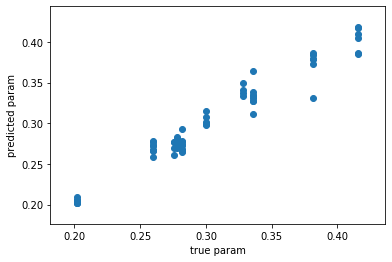

In [ ]:
scatter(params.cpu()[:,1], outputs.cpu()[:,1])
xlabel('true param')
ylabel('predicted param')

In [ ]:
# Saving fairly well trained model
torch.save(model_ft.state_dict(), 'resnet18_state_dict')

In [ ]:
torch.save(model_ft, 'resnet18')